# Deep Neural Networks for YouTube Recommendations

---

## 1. Introduction

YouTube의 video를 추천하는 과정은 다음 3가지 이유로 매우 어렵다

1. **Scale**: YouTube에는 셀 수 없이 많은 영상들이 존재한다. 그에 반해, 대부분의 recommendation algorithm은 대게 small problem만을 잘 수행한다.
2. **Freshness**: YouTube에는 실시간으로 엄청난 양의 영상이 업로드 된다. 또한, user들이 실시간 피드백을 날리는 것도 고려하였을 때, 이를 바로바로 반영하는 것은 매우 어렵다.
3. **Noise**: 이 분야에 대한 ground truth도 없고, user 피드백의 대부분은 implicit feedback으로, 중요한 정보만을 추출하는 것이 매우 어렵다.

---

## 2. System Overview

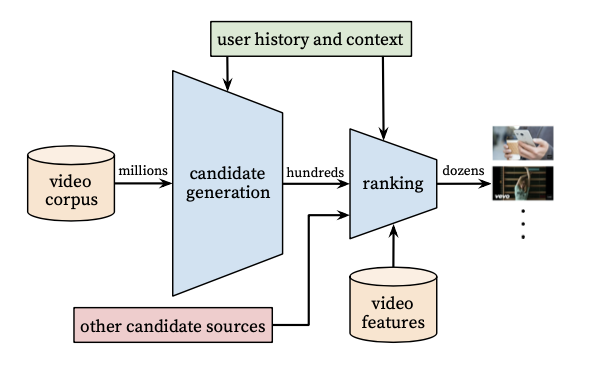

In [3]:
from PIL import Image
Image.open('Images/model_structure.png')

model의 전반적인 구조는 위와 같다.

크게는 2가지 network로 이루어져 있다.

1. **``Candidate Generation Network``**: 수백만개의 video corpus에서부터 추천 할 비디오를 몇백개 내외로 뽑아내는 단계. Collaborative Filtering을 통한 넓은 수준의 personalization을 수행하며, high precision을 목표로 함.

2. **``Ranking Network``**: 실제로 추천을 진행 할 단 몇개의 동영상을 선택하는 단계. Objective function을 통해 score를 매기고 그를 기반으로 ranking을 뽑아 추천을 진행한다.


개발 과정에서는 다양한 평가지표를 사용하지만, 최종 결정 단계에서는 A/B test를 진행한다. 

---

## 3. Candidate Generation

기존에는 Recommendation에 **Matrix Factorization**이 사용되었다. 또한 그 후의 초기 Neural Network model은 MF를 user의 시청기록만을 이용하여 따라하였다.

### 3.1 Recommendation as Classification

user에게 video를 추천하는 이 youtube의 문제를, 마치 엄청나게 많은 class가 있는 multiclass classification 문제로 해석해보자.

user와 context에 대한 정보(U, C)가 주어졌을 때, 특정 시간(i)에 이 영상(영상 클래스)를 볼 확률은 다음과 같다.

$$P(w_t = i|U, C) = {e^{v_iu} \over \sum_{j \in V} e^{v_ju} \ }$$

여기서 $v$는 각각의 video의 embedding, $u$는 user와 context의 embedding이다.

이 문제에서, neural network의 목표는 user의 history와 context를 가지고 적절한 **embedding u를 만드는 함수**를 찾는 것이다.


#### Implicit Feedback
물론 youtube에는 explicit feedback data도 존재하지만(좋아요/싫어요, 설문조사 결과 등), 본 model에서는 implicit data를 사용한다. implicit data가 그 양도 훨씬 많고, 상대적으로 덜 sparse하기 때문이다.

#### Extreme Multiclass classification
class가 엄청나게 많기 때문에, 효율적으로 계산하는 것이 매우 중요하다.

1. offline(실시간이 아닌, 미리 계산해 놓는 단계)
        **negative sampling** 사용 - multi-class classification 문제를 binary classification 문제로 바꾼다.
        
2. serving time(실시간)
        매우 빠르게 연산을 처리해야하기때문에, sublinear한 알고리즘이 필요하다.
        여기서는 nearest neighbor search를 진행한다.

### 3.2. Model Architecture

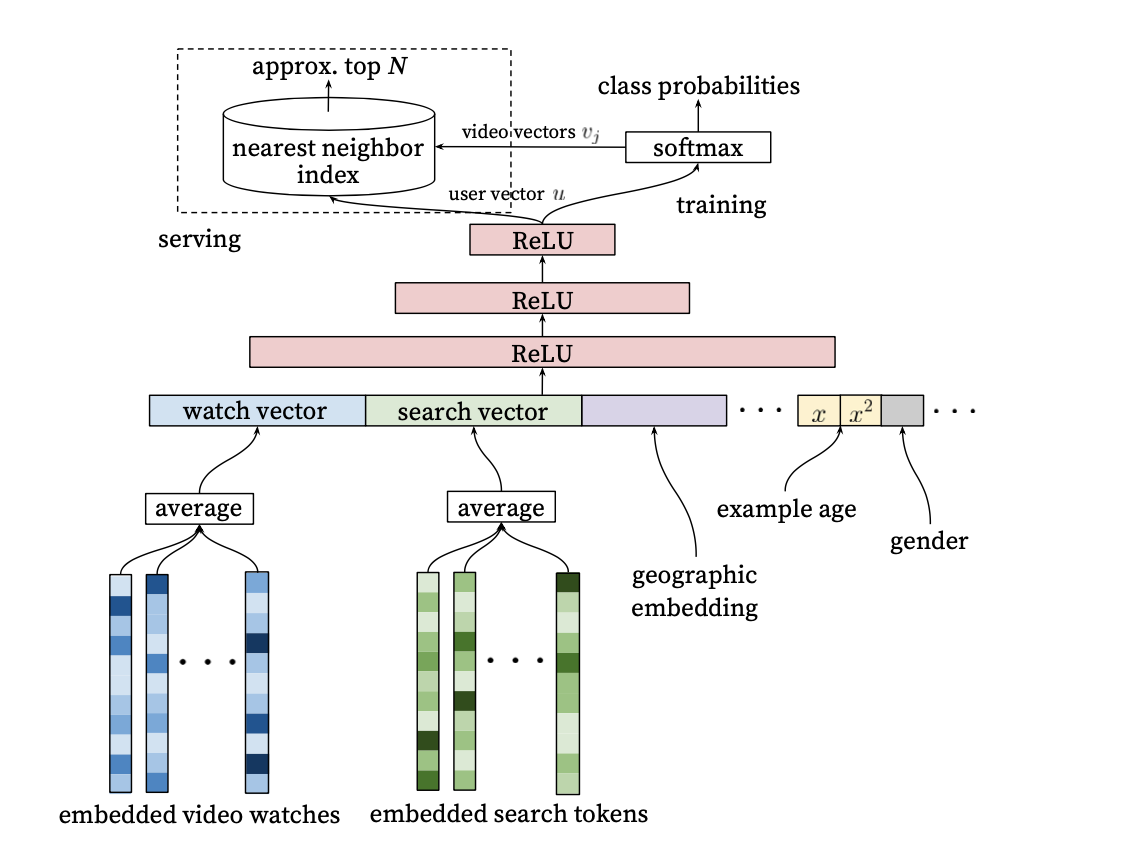

In [4]:
Image.open('Images/model.png')

user가 본 video들을 좌측 하단의 embedding으로 변환한 후, embedded vector들을 평균내어 fixed-size의 watch vector로 변환

### 3.3 Heterogeneous Signals

DNN을 사용하므로서 얻게 되는 이점 중 하나는, categorical / arbitrary continuous feature를 matrix factorization에 비해 쉽게 다룰 수 있다는 점이다. 

#### Search History
검색 기록은 위에서 언급한 시청 기록과 유사하게, embedding 시킨 후 평균을 취하여 fixed-size vector로 사용한다.

#### Demographic Feaures
어떤 동영상을 찾고 보았는 지 뿐만 아니라, user가 어떤 사람인지도 중요한 변수가 될 수 있다. 따라서 해당 변수들을 역시 embedded되어 시청 기록 및 검색 기록과 함께 concatenate된다.

#### Example Age 
(*Youtube의 특성을 반영한 변수*)

Youtube에서는 새롭게 올라오는 동영상을 밀어주는 것이 중요하다. 하지만 ML system 과거의 경향성을 학습하기 때문에 필연적으로 과거 데이터에 살짝 편향된다. 또한 영상의 인기도는 시간에 따라 극명하게 차이나기 마련인데, 기존의 model은 이를 반영하지 못하고 인기가 평균적으로 유지되었다고 가정한다. 따라서, 본 model에서는 video의 **age** 역시 학습 변수로 포함시켜준다.

### 3.4 Label and Context Selection
(이 부분 이해 잘 못했음 ㅠㅠ)

#### Training Data
1. training data로는 youtube의 모든 시청기록과 다른 사이트에서 쌓인 데이터까지 포함한다. 추천 시스템으로 인해 발생한 시청 기록만을 training data로 사용한다면, recommender는 갈수록 스스로에게 편향 될 것이기 때문이다.

2. 한 user에서 뽑을 수 있는 training example의 수를 제한한다. 이를 통해, 엄청나게 많이 시청하는 소수의 user들에 전체 training data가 편향되는 것을 막을 수 있다.

3. 수집된 정보를 classifier에 바로 training 시키지 않는다. 특정 검색어를 검색했다고 해서, 해당 검색어와 관련된 영상을 홈에서까지 곧바로 추천하는 것이 오히려 비효율적임이 밝혀졌기 때문이다(이미 한번 봤기 때문인 듯).

#### Natural Consumption Pattern
영상 시청에 관련된 몇가지 패턴들이 있다.
* 시리즈 물은 연속적으로 시청이 일어난다.
* 음악은 유명한 곡으로 시작해서 minor한 곡을 듣는 순서로 청취한다.


---

## 4. Ranking

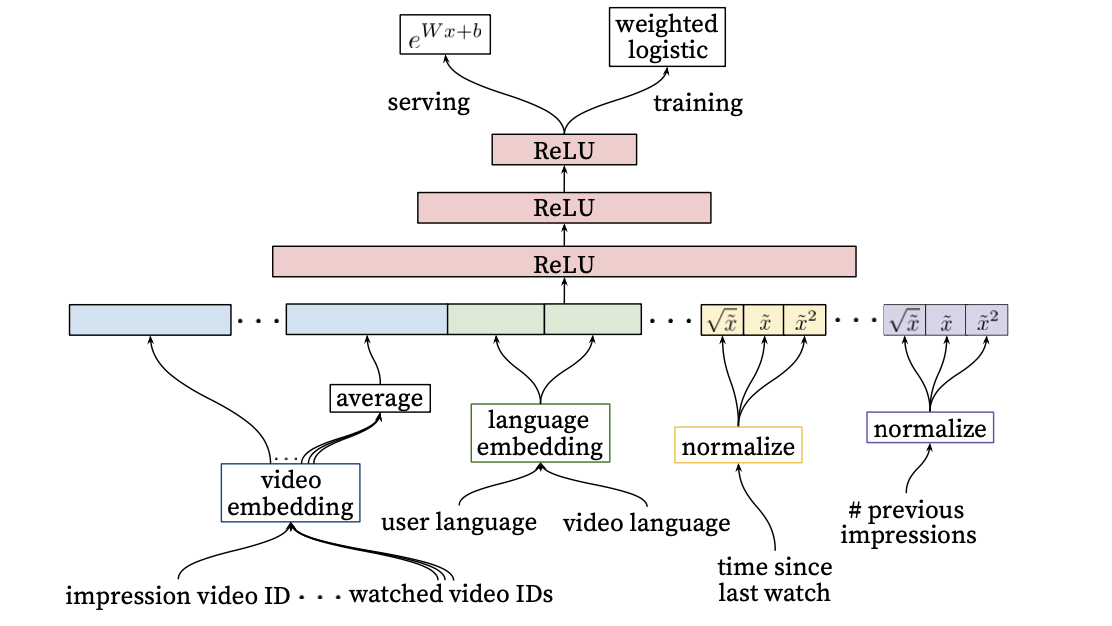

In [5]:
Image.open('Images/model_level_2.png')

최종적으로 user에게 video를 추천해주는 단계! 이 단계에서는 user와 video의 relationship을 설명 할 수 있는 훨씬 더 다양한 변수들을 사용한다. 이전의 candidate generation 단계와는 다르게, 몇 백개의 후보만을 검토하면 되므로 복잡한 변수 사용이 가능하다.

당연히 ranking 단계에서도 DNN을 사용한다. DNN을 통해 최종적인 video별 score를 도출 할 수 있고, 이 score의 rank에 따라 user에게 video가 노출된다. 그리고 이 노출 순서(ranking)은 실시간 A/B test를 통해 지속적으로 관리된다. 이 때, 평가지표로는 클릭률이 아닌 노출 대비 **평균 감상 시간**이 사용된다.

### 4.1 Feature Representation
다양한 feature를 사용하는 만큼, 이 feature들을 어떻게 구분하고 다룰 지가 중요한 issue이다.

같은 Categorical data라고 하더라도, 어떤 feature는 binary data인 반면에, 다른 feature는 가능한 값이 수백만개 일 수도 있다. 또한 어떤 feature는 item(impression)을 설명하는 반면, 다른 feature는 user/context (query)를 설명하기도 한다. 이들을 어떻게 다룰 지가 가장 핵심이 되는 issue이다.

#### Feature Engineering
model의 input이 되는 data의 형식이 너무 다양하므로, 어느정도의 engineering이 필요하다. 

특히, user의 최근 action들과 video의 여러 정보들이 어떤 관계가 있는 지 파악하는 것이 중요하다. 예를 들어, 이 주제의 video를 가장 최근에 본 적이 언제인 지, 이 채널의 video를 몇개나 보았는 지 등의 정보가 있다. 또한 candidate generation에서 얻은 정보를 사용한다던가, 이미 추천했지만 시청되지 않은 영상은 어떻게 처리 할 지 등 고려해볼만한 요소가 정말 많다.

#### Embedding Categorical Features
candidate generation에서 그랬듯이, 다양한 categorical feature를 embedding해야 한다. 이 때, 가장 많이 클릭 된 N개의 video와 관련된 data(video ID, search query 등)을 제외한 다른 feature는 0으로 처리한다.

같은 ID space에 존재하는 categorical feature들은 같은 embedding을 공유한다. 하지만 같은 embedding을 공유한다고 해서, 모두가 average되는 것은 아니다. 각각 다른 의미를 담고 있기 때문이다(그러니까 watched video의 embedding은 average 되겠지만, watched video와 impression video ID가 average되지는 않는다).

#### Normalizing Continuous Features
Neural Net은 scaling에 sensitive하기 때문에, normalizing이 매우 중요하다. 이 때, 단순 normalizing 이외에도 non-linearity를 잘 표현하기 위해 $\sqrt x, x^2$도 input으로 넣어준다.

### 4.2 Modeling Expected Watch Time
결국 modeling의 목적은 **Expected Watch Time**을 예측하는 것이다. training example은 positive(실제로 시청이 일어남)일 수도, negative(시청되지 않음)일 수도 있다. Expected watch time을 예측하기 위해, 본 model은 **weighted logistic regression**이라는 방법을 사용한다.


### 4.3 Experiment with Hidden Layers
측정 기준: **Weighted per-user Loss** = 전체 시청 시간 대비 *mispredicted watch time*(negative impression보다 낮은 점수를 받은 positive impression의 watch time)

Layer의 depth와 width를 바꿔가며 실험 진행